# Convolutional Neural Networks: Application

Trong notebook này ta sẽ:

- Lập trình các hàm hỗ trợ khi xây dựng model bằng Tensorflow
- Thực hiện training bằng CNN với TensorFlow 

**Sau khi hoàn thành bài tập này, bạn sẽ có thể:**

- Xây dựng và huấn luyện mạng CNN cho các bài toán phân loại

## 1.0 - TensorFlow model

In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

Chạy Cell dưới đây để load dataset "SIGNS" dùng cho bài toán

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Dataset SIGNS chứa 6 kí hiệu tay đại diện cho 6 con số từ 0 to 5. 

<img src="images/SIGNS.png" style="width:800px;height:300px;">

y = 2


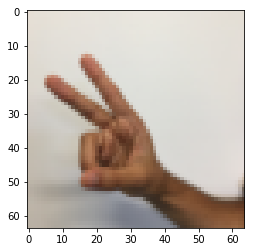

In [3]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Đầu tiên, ta sẽ xem qua kích thước của dữ liệu

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 1.1 - Create placeholders

TensorFlow yêu cầu chúng ta tạo ra các placeholder để nạp dữ liệu vào khi chạy session.

**Exercise**: Lập trình hàm để tao placeholder cho ảnh đầu vào X và nhãn Y. Bạn chưa nên fix cứng số bản ghi tại thời điểm này. Dùng "None" để đại diện cho kích thước của batch_size sẽ giúp ta thay đổi kích thước batch huấn luyện một cách dễ dàng. Vì thế X sẽ có kích thước là **[None, n_H0, n_W0, n_C0]** và Y sẽ có kích thước là **[None, n_y]**.  [Hint](https://www.tensorflow.org/api_docs/python/tf/placeholder).

In [5]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    ### END CODE HERE ###
    
    return X, Y

In [6]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


**Expected Output**

<table> 
<tr>
<td>
    X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)

</td>
</tr>
<tr>
<td>
    Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)

</td>
</tr>
</table>

### 1.2 - Khởi tạo tham số

Ta sẽ khởi tạo tham số/bộ lọc $W1$ and $W2$ với `tf.contrib.layers.xavier_initializer(seed = 0)`. Chúng ta không cần quan tâm đến bias vì nó sẽ được khởi tạo tự động bởi Tensorflow. Đồng thời, ta sẽ chỉ cần khởi tạo tham số cho những hàm conv2d. Những tầng fully connected được khởi tạo tham số một cách tự động.

**Bài tập:** Lập trình hàm initialize_parameters(). Kích thước của mỗi nhóm filters được cho dưới đây. Để khởi tạo một tham số  $W$ có kích thước [1,2,3,4] trong Tensorflow, ta dùng:
```python
W = tf.get_variable("W", [1,2,3,4], initializer = ...)
```
[More Info](https://www.tensorflow.org/api_docs/python/tf/get_variable).

In [11]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [12]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


**Expected Output:**

```
W1[1,1,1] = 
[ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W2.shape: (2, 2, 8, 16)
```

### 1.2 - Forward propagation

Trong TensorFlow, ta có những hàm build sẵn giúp ta thực hiện bước convolution.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** với một input $X$ và một bộ lọc $W1$, hàm này thực hiện phép nhân tích chập giữa $W1$ và X. Đầu vào thứ ba, ([1,f,f,1]) đại diện cho số bước nhảy với mỗi kích thước đầu vào (m, n_H_prev, n_W_prev, n_C_prev). Đọc thêm [tại đây](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** cho đầu vào là A, hàm này sẽ sử dụng một cửa số có kích thước (f, f) và bước nhảy là (s, s) để thực hiện max pooling với mỗi vùng ảnh. Đọc thêm [tại đây](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** tính toán đầu ra của hàm ReLU với ma trận đầu vào Z1 (kích thước bất kì). Đọc thêm[tại đây.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: Với dữ liệu đầu vào P, hàm này sẽ duỗi mỗi bản ghi thành một vector một chiều, và giữ nguyên batch size, đầu ra là một tensor với kích thước [batch_size, k]. Đọc thêm [tại đây.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** Cho một đầu và đã được flatten F, hàm sẽ tạo ra một layer fully connected với số neuron = num_outputs. Đọc thêm [tại đây.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

Trong hàm cuối cùng phía trên (`tf.contrib.layers.fully_connected`), tầng fully connected tự động khởi tạo tham số trong đồ thị và liên tục cập nhật tham số trong quá trình huấn luyện. 


**Exercise**: 

Lập trình hàm `forward_propagation` với kiến trúc sau: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. Sử dụng các hàm được nhắc đến phía trên. 

Cụ thể, ta sẽ sử dụng những tham số sau cho tất cả các bước:
     - Conv2D: stride 1, padding "SAME"
     - ReLU
     - Max pool: Bộ lọc kích thước 8x8 và bước nhảy là 8x8, padding "SAME"
     - Conv2D: stride 1, padding "SAME"
     - ReLU
     - Max pool: Bộ lọc kích thước là 4 x 4 và bước nhảy là 4x4, padding "SAME"
     - Flatten đầu ra của lớp max pool.
     - FULLYCONNECTED (FC) layer: Đắp một tầng fully connected không sử dụng activation phi tuyến. Chúng ta không gọi hàm softmax ở đây. Kết quả của hàm sẽ là 6 neurons trong output layer để đưa vào softmax sau đó. Trong TensorFlow, hàm softmax và cost được tổng hợp cùng với nhau thành một hàm mà ta sẽ gọi sau. 

In [21]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
   
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    ### END CODE HERE ###

    return Z3

In [22]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[-0.44670227 -1.57208765 -1.53049231 -2.31013036 -1.29104376  0.46852064]
 [-0.17601591 -1.57972014 -1.4737016  -2.61672091 -1.00810647  0.5747785 ]]


**Expected Output**:

```
Z3 = 
[[-0.44670227 -1.57208765 -1.53049231 -2.31013036 -1.29104376  0.46852064]
 [-0.17601591 -1.57972014 -1.4737016  -2.61672091 -1.00810647  0.5747785 ]]
```

### 1.3 - Tính cost

Lập trình hàm cost dưới đây. Bạn có thế sử dụng các hàm sau: 

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** tính softmax entropy loss. Hàm này kết hợp cả softmax activation function với hàm loss. Đọc thêm [tại đây.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** tính giá trị trung bình của các phần tử theo một trục nào đấy của một tensor. Sử dụng hàm này để tính kết quả loss trung bình của tất cả các bản ghi để ra cost. Đọc thêm [tại đây.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

**Bài tập**: Lập trình hàm cost sử dụng các hàm được gợi ý.

In [23]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [24]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 2.91034


**Expected Output**: 
```
cost = 2.91034
```

## 1.4 Model 

Cuối cùng, ta sẽ hợp nhất những hàm phía trên thành một model. Sau đó sử dụng moddel này để huấn luyện với dataset SIGNS. 


**Bài tập**: Hoàn thiện hàm dưới đây. 

Model hoàn chỉnh sẽ có những phần sau:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

Với mỗi epoch trong quá trình huấn luyện, ta sẽ lấy ra những mini-batch để huấn luyện và cập nhật trọng số theo từng batch. [Hint for initializing the variables](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)

In [37]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Chạy đoạn code dưới với 100 epochs. Kiểm tra giá trị cost sau epoch 0 và 5 có đúng với expected output không. Nếu không, bạn nên ngừng chạy và quay lại kiểm tra code!

Cost after epoch 0: 1.917929
Cost after epoch 5: 1.506757
Cost after epoch 10: 0.955359
Cost after epoch 15: 0.845802
Cost after epoch 20: 0.701174
Cost after epoch 25: 0.571977
Cost after epoch 30: 0.518435
Cost after epoch 35: 0.495806
Cost after epoch 40: 0.429827
Cost after epoch 45: 0.407291
Cost after epoch 50: 0.366394
Cost after epoch 55: 0.376922
Cost after epoch 60: 0.299491
Cost after epoch 65: 0.338870
Cost after epoch 70: 0.316400
Cost after epoch 75: 0.310413
Cost after epoch 80: 0.249549
Cost after epoch 85: 0.243457
Cost after epoch 90: 0.200031
Cost after epoch 95: 0.175452


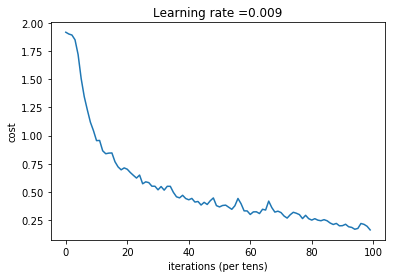

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.940741
Test Accuracy: 0.783333


In [38]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

**Expected output**: kết quả đầu ra nên khá gần tương tự với những giá trị sau.

- **Cost after epoch 0 =** 1.917929
- **Cost after epoch 5 =** 1.506757
- **Train Accuracy   =** 0.940741
- **Test Accuracy   =**  0.783333

Chúc mừng! Bây giờ bạn đã biết xây dựng một model CNN với Tensorflow. Nếu muốn, bạn có thể hiệu chỉnh tham số để cải độ chính xác.

Thumb up to your work!

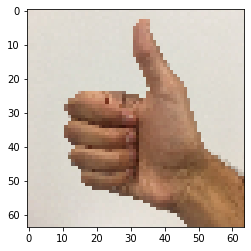

In [16]:
import cv2
fname = "images/thumbs_up.jpg"
image = cv2.imread(fname)
my_image = cv2.resize(image, dsize=(64,64))
plt.imshow(cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB))